<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 &ndash; Convolutional Neural Networks</h2>

<b>Authors:</b> Brandstetter, Schäfl, Schlüter, Rumetshofer, Schörgenhumer<br>
<b>Date:</b> 09-01-2023

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u6_utils.py</code> need to be installed.

A new package compared to the last lectures is <code>opencv</code> (<code>cv2</code>) (<a href="https://pypi.org/project/opencv-python/">installation instructions</a>).

In [ ]:
# Import pre-defined utilities specific to this notebook.
import u6_utils as u6

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import torch

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [ ]:
u6.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.21.5 (✓)
Installed pandas version: 1.4.2 (✓)
Installed scikit-learn version: 1.0.2 (✓)
Installed matplotlib version: 3.5.1 (✓)
Installed seaborn version: 0.11.2 (✓)
Installed torch version: 1.13.0 (✓)
Installed tqdm version: 4.64.0 (✓)
Installed cv2 version: 4.7.0 (✓)


<h2 style="color:rgb(0,120,170)">What is a convolutional neural network?</h2>

A **convolutional neural network** (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing all sorts of images. The name indicates that the network employs a **mathematical operation called convolution**. Convolutional networks are any neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

Like other neural networks, a convolutional neural network consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of **convolutional layers**, **pooling layers** and **fully connected layers**.

<img src="inputs/sketch_cnn.jpg"/>
Source: Peng et al. "Dual Temporal Scale Convolutional Neural Network for Micro-Expression Recognition". Frontiers in Psychology, 8. 2017.
<br><br>

<img src="inputs/cnn_architecture.jpg"/>
Source: Elisabeth Rumetshofer

<h2 style="color:rgb(0,120,170)">What is convolution?</h2>

Discrete **convolution** is a mathematical operation on two tensors (of the same dimensionality, but possibly of different size) to produce a third tensor. The term convolution refers to both the resulting tensor and to the process of computing it. In a neural network that processes images, the first tensor is the input image, and the second one is a learnable **filter** or **kernel**, the size of which we choose in advance. The operation can be seen as sliding the (small) filter over the (large) image and computing a weighted sum (or dot product) for every position. One step looks as follows:

<img src="inputs/cnn_concept_1.jpg" width="500"/>

(Technically, for a convolution, the filter needs to be flipped horizontally and vertically before sliding it over the input, otherwise it is called a **cross-correlation**. This flipping is usually omitted, but we still call it a convolutional neural network. Since the filters are learned, it does not make a difference.)

By applying the learnable filter at every position, we obtain an output image, the so-called **activation map**. It can be seen as recording the activation strength of some specific feature at some spatial position in the input. For the example above, we would get:

In [ ]:
image = np.array([
    [0,   0,   0,   0,   0,   0],
    [0, 1.0,   0,   0, 0.4,   0],
    [0,   0,   0, 0.4,   0,   0],
    [0,   0,   0,   0, 0.4,   0],
    [0,   0,   0, 0.4,   0,   0],
    [0,   0,   0,   0, 0.4,   0]
])
kernel = np.array([
    [0,   0, 0.5],
    [0, 0.5,   0],
    [0,   0, 0.5]
])
# Filter the image using filter2D, which has inputs: (image, bit-depth, kernel)  
cv2.filter2D(image, -1, kernel)[1:-1, 1:-1]

array([[0.5, 0.2, 0. , 0.2],
       [0. , 0. , 0.6, 0. ],
       [0. , 0.4, 0. , 0.2],
       [0. , 0. , 0.6, 0. ]])

Note how the activations are strongest when the pattern of "0.5" in the kernel overlaps with the pattern of "0.4" in the input, giving $0.5 \cdot 0.4 + 0.5 \cdot 0.4 + 0.5 \cdot 0.4 = 0.6$. Also note that the output is smaller than the input by 2 pixels in each dimension &mdash; we could *pad* the input with a suitably large border of zeros if we wanted to avoid that (OpenCV pads by default, this is why performed some slicing directly after ``filter2D``).

<h2 style="color:rgb(0,120,170)">Creating a filter</h2>

Let us get some more intuition of what we can do with convolutions. We first read in an image of Charlie and convert it to grayscale:

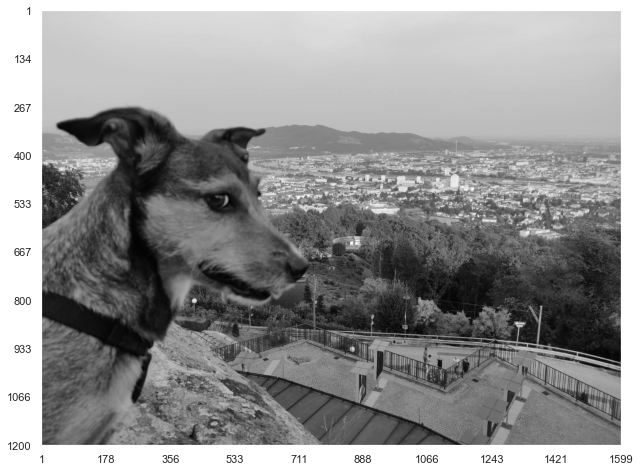

In [ ]:
image = plt.imread("resources/charlie_4.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
u6.show_image(image)

Below we define a common type of edge detection filter, **a Sobel operator**. The Sobel filter is very commonly used in edge detection and in finding patterns in intensity in an image. Applying a Sobel filter to an image is a way of **taking (an approximation) of the derivative of the image** in the x direction ("columns" $\rightarrow$ vertical edge detection) or y direction ("rows" $\rightarrow$ horizontal edge detection), respectively. The operators look as follows:

$S_x = \left[
\begin{array}{rrr}                                
-1 & 0 & 1 \\                                               
-2 & 0 & 2 \\                                               
-1 & 0 & 1 \\                                               
\end{array}
\right]$

$S_y = \left[
\begin{array}{rrr}                                
-1 & -2 & -1 \\                                               
0 & 0 & 0 \\                                               
1 & 2 & 1 \\                                               
\end{array}
\right]$

See what happens if we ~~convolve~~ cross-correlate such a filter with our image:

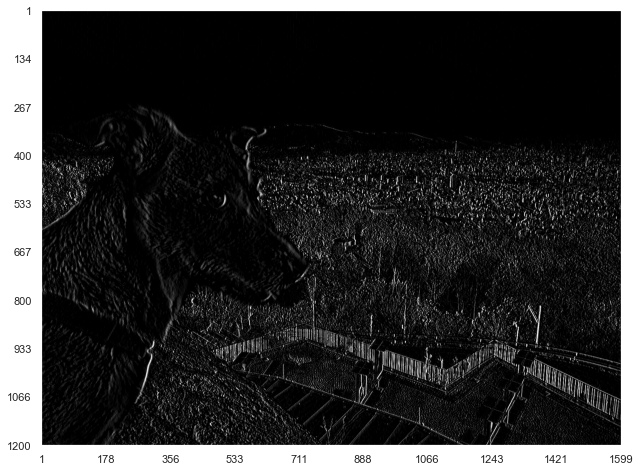

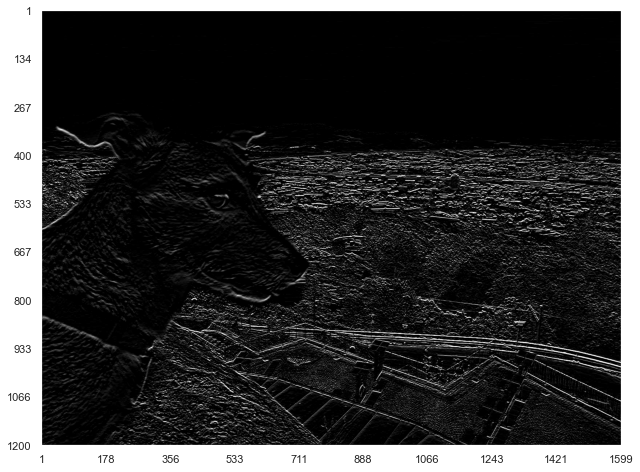

In [ ]:
# 3x3 array for edge detection
sobel_x = np.array([
    [ -1,  0,  1],
    [ -2,  0,  2],
    [ -1,  0,  1]
])
sobel_y = np.array([
    [ -1, -2, -1],
    [  0,  0,  0],
    [  1,  2,  1]
])

# A side note: cv2.filter2D clips the resulting value to [0, 255], i.e., all negative values will simply be treated as black pixels and
# all positive values > 255 will be treated as white pixels.
filtered_image = cv2.filter2D(image, -1, sobel_x)  # add [1:-1, 1:-1] to extract the unpadded data
u6.show_image(filtered_image)
filtered_image = cv2.filter2D(image, -1, sobel_y)  # add [1:-1, 1:-1] to extract the unpadded data
u6.show_image(filtered_image)

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>Apply your filters to the other images in the ''resources'' directory. What do you observe?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Some CNN building blocks</h2>

We now look closer into some important building blocks of a convolution neural network. Concretely, we study the following operations: **(i) convolution using filters**, **(ii) applying activation functions**, **(iii) pooling**, **(iv) stride**. For a nice visualization, see this link: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md or this link: https://poloclub.github.io/cnn-explainer/#article-convolution (under subsection "Understanding Hyperparameters").

<h3 style="color:rgb(0,120,170)">(i) Convolution using filters</h3>

A single filter can only capture a single feature. In a CNN, each convolutional layer thus learns **multiple filters**, and produces multiple activation maps (also called feature maps). The number of filters can be decided at will, just like we can freely decide the number of units in a fully-connected layer.

Here, we define `filter_1` and calculate three additional filters out of `filter_1`:

In [ ]:
# Define filter 1
filter_1 = np.array([
    [-1, -1, 1, 1],
    [-1, -1, 1, 1],
    [-1, -1, 1, 1],
    [-1, -1, 1, 1]
])
print(f"Filter shape: {filter_1.shape}")

Filter shape: (4, 4)


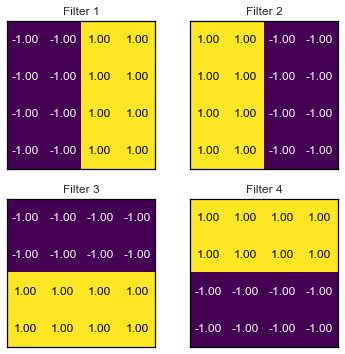

In [ ]:
# Define filters 2, 3 and 4
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

u6.visualize_filters(filters)

We use these filters to instantiate a small Convolutional Neural Network in PyTorch:

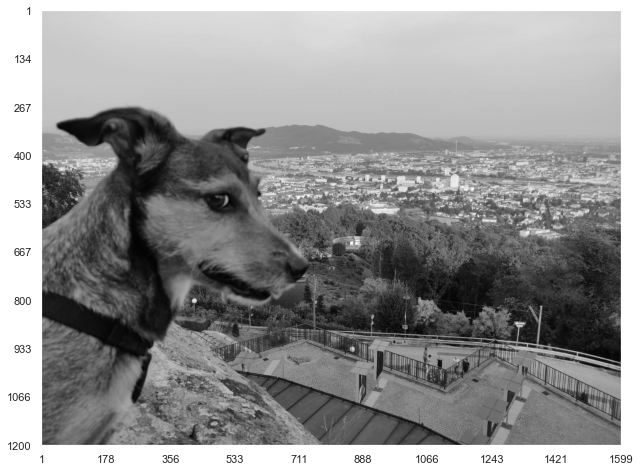

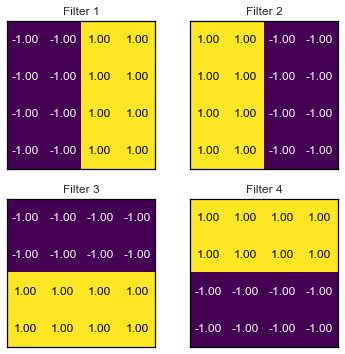

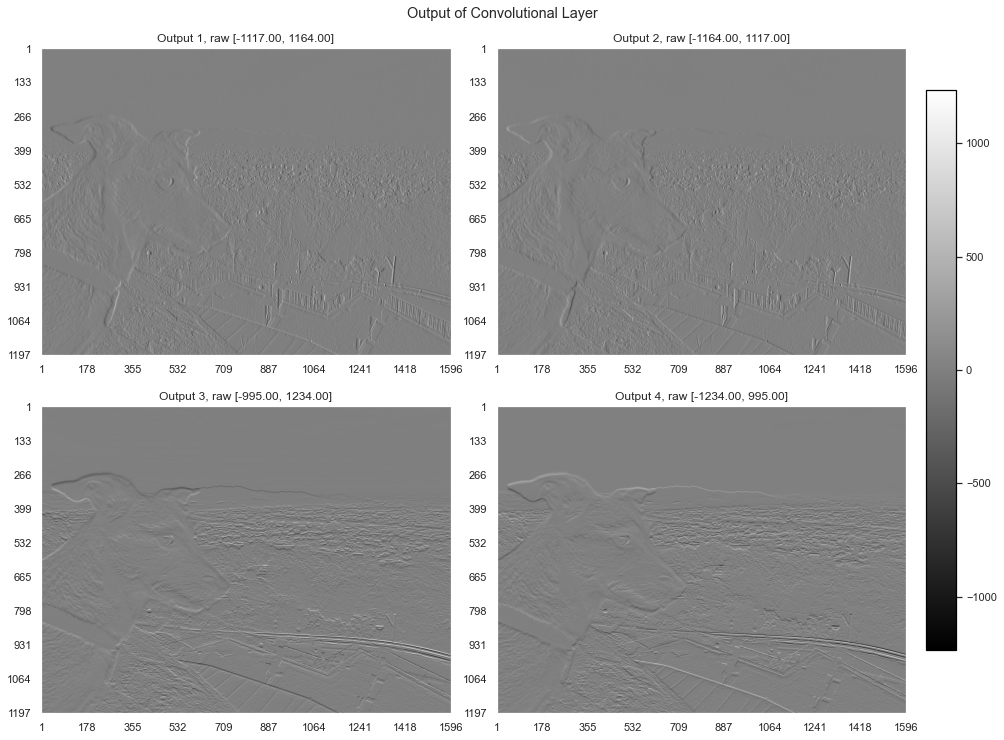

In [ ]:
u6.show_image(image)
u6.visualize_filters(filters)

# Instantiate the weights for the model, using the filters from above, and transform the image data to a tensor so we can input it to our model
model = u6.InitializedNet(weights=filters)
image_tensor = u6.get_grayscale_image_tensor(image)

# Get the convolutional layer before activation (return values are: conv_output, activation_output, maxpool_output; see further below)
conv_layer, _, _ = model(image_tensor)
# Visualize the output of the convolutional layer (you can change the visualization with parameters "cmap", "clip" and "shift")
u6.visualize_cnn_layer(conv_layer, title="Output of Convolutional Layer")

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>Create 4 new filters: "filter_1" is Sobel operator $S_X$, "filter_2" is the negative Sobel operator $S_X$, "filter_3" is the Sobel operator $S_Y$, "filter_4" is the negative Sobel operator $S_Y$. Do you see any differences?</li>
        <li>Apply your filters to the other images in the ''resources'' directory. What do you observe?</li>
    </ul>
</div>

<h3 style="color:rgb(0,120,170)">(ii) Applying activation functions</h3>

We now use an activation function that scales the outputs of the convolutional layer. We choose a **ReLU function** (Rectified Linear Unit) to do this, and this function simply turns all negative pixel values to $0$ (black) and leaves the positive values unchanged. 

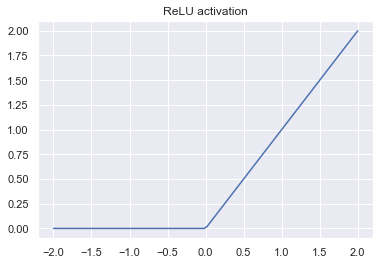

In [ ]:
x = np.linspace(-2, 2, 100)
sns.lineplot(x=x, y=np.maximum(0, x))
plt.title("ReLU activation");

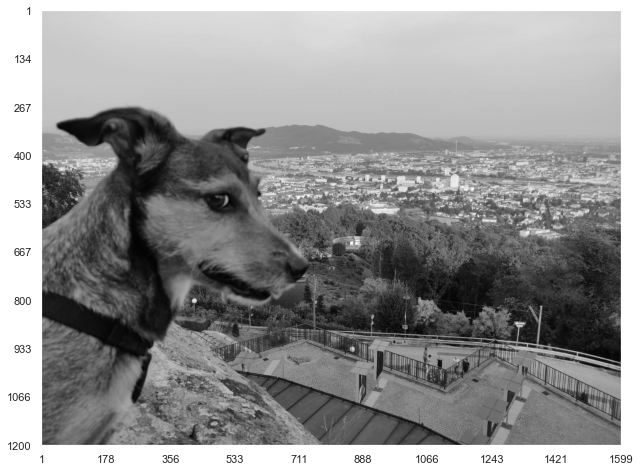

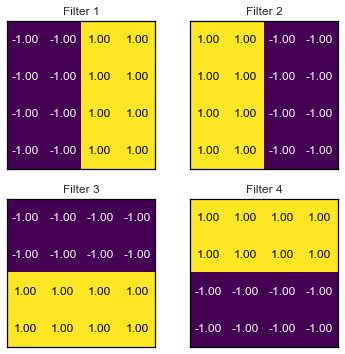

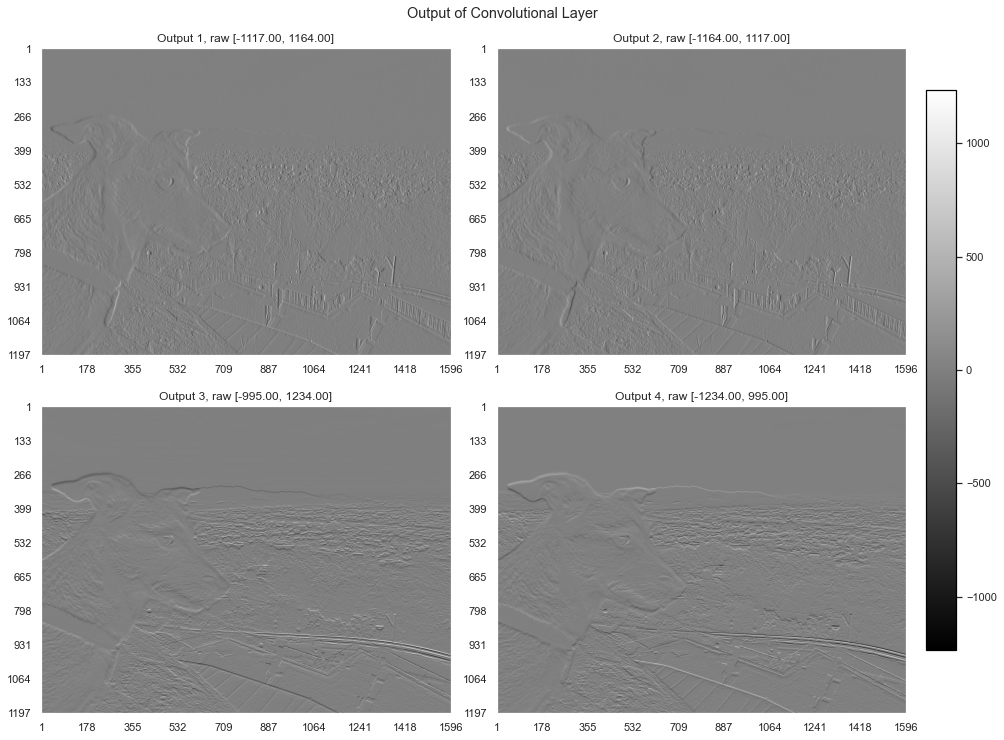

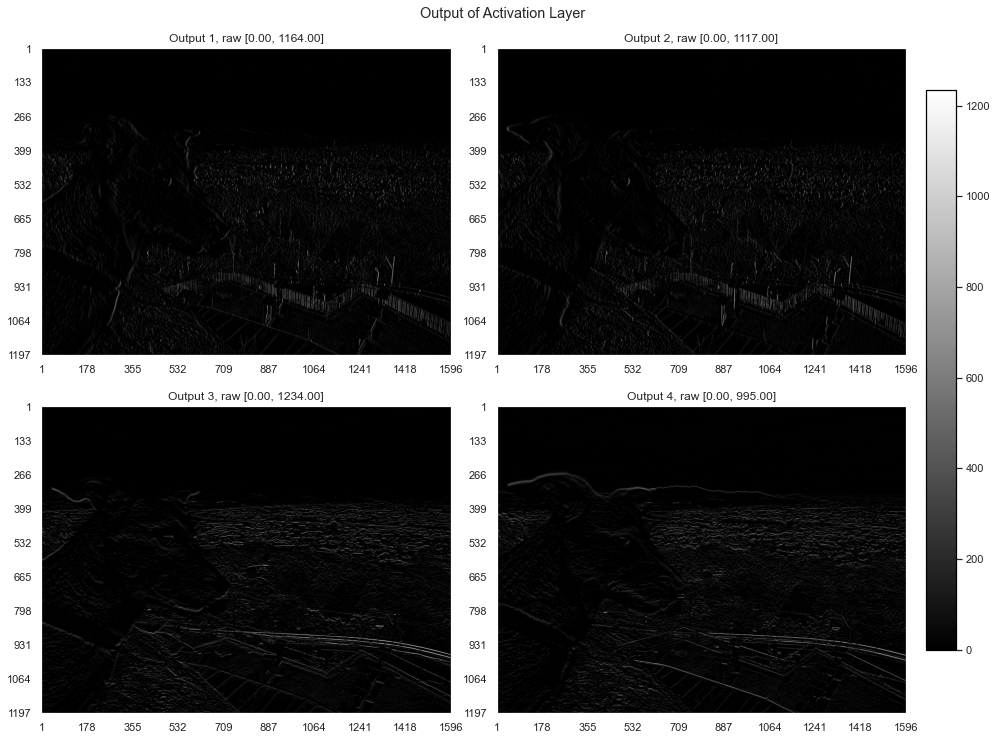

In [ ]:
u6.show_image(image)
u6.visualize_filters(filters)

# The activation function can be changed (default is ReLU); see https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
model = u6.InitializedNet(weights=filters, activation=torch.nn.ReLU())

# Get the convolutional layer before and after activation
conv_layer, activated_layer,  _  = model(image_tensor)
# Visualize the outputs of these layers
u6.visualize_cnn_layer(conv_layer, title="Output of Convolutional Layer")
u6.visualize_cnn_layer(activated_layer, title="Output of Activation Layer")

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>What happens if you try a different activation function? You can do this by supplying a different function when creating the model (class "InitializedNet").</li>
        <li>Apply your filters to the other images in the ''resources'' directory. What do you observe?</li>
    </ul>
</div>

<h3 style="color:rgb(0,120,170)">(iii) Max pooling</h3>

Another important concept often used with CNNs is **pooling**, which is a form of nonlinear down-sampling. There are several nonlinear functions to implement pooling, among which **max pooling** is the most common. It partitions the input image into a set of non-overlapping rectangles and, for each such sub-region, outputs the maximum. The size of the rectangles can be chosen at will. Processing the result from our very first convolution example with 2x2 max-pooling, the first output would be:

<img src="inputs/cnn_mp_0.jpg" width="350"/>

For many tasks, the exact location of a feature is less important than its rough location relative to other features. This is the idea behind the use of pooling in convolutional neural networks. The pooling layer serves to progressively reduce the spatial size of the representation, to reduce the memory required to store activations.

In our small CNN, on top of the activation we now apply a max pooling operation which takes the **maximum value of 5x5 pixels**.

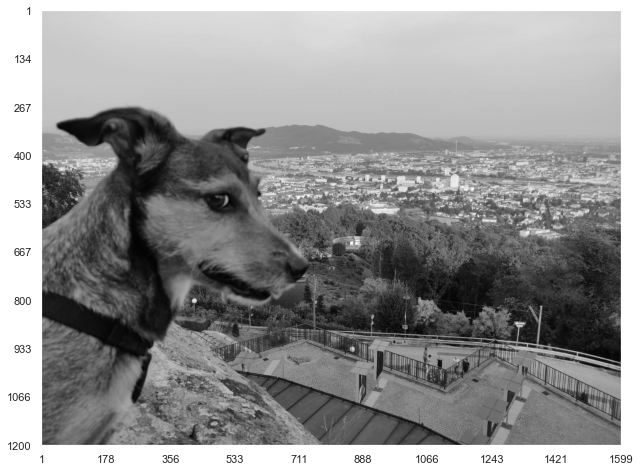

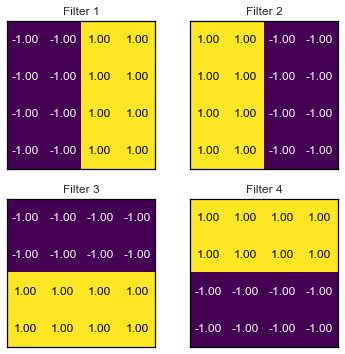

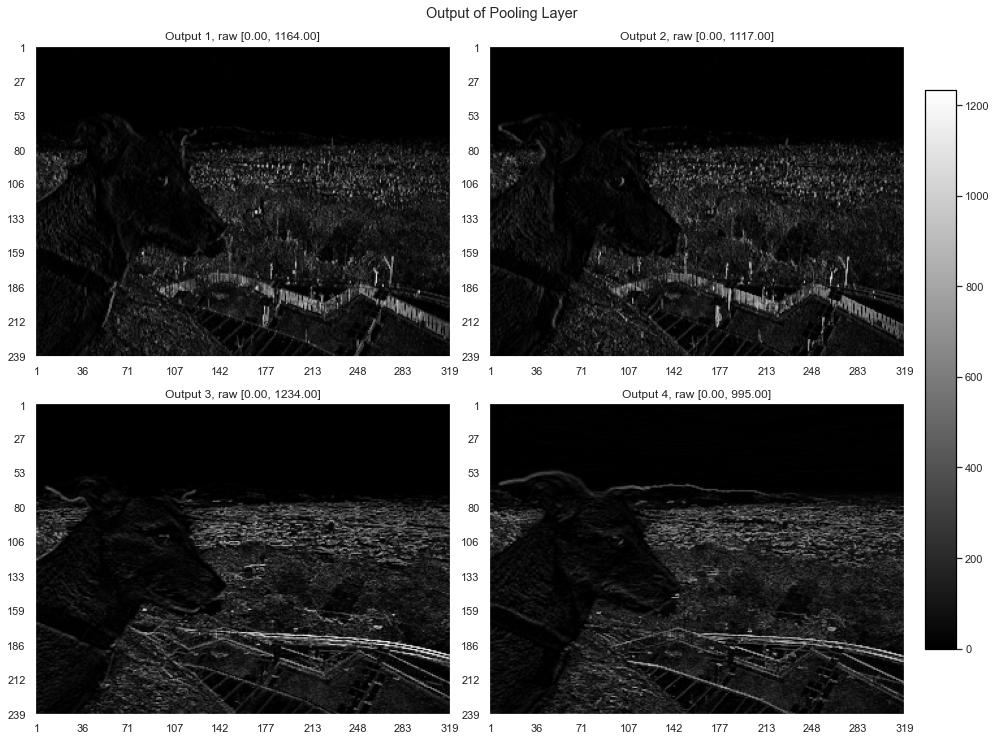

In [ ]:
u6.show_image(image)
u6.visualize_filters(filters)

# The length and width of the max pooling operation can be changed
model = u6.InitializedNet(weights=filters, max_pool_size=(5, 5))  # read as (height, width)

# Get the convolutional layer before and after activation, as well as the pooling layer
conv_layer, activated_layer, pooling_layer = model(image_tensor)
# Visualize the output of this last layer
u6.visualize_cnn_layer(pooling_layer, title="Output of Pooling Layer")

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>What happens if you change the size of the max pooling operation?</li>
        <li>Apply your filters to the other images in the ''resources'' directory. What do you observe?</li>
    </ul>
</div>

<h3 style="color:rgb(0,120,170)">(iv) Stride</h3>

Another way to reduce the output size of a convolutional layer, other than performing max pooling, is to set a **stride** for the convolution operation. The stride controls by how many pixels a filter is moved when sliding it over the input image.
For example, with a stride of 3 the filter only inspects every third pixel, effectively reducing the output size. A stride can also be used with the pooling operation itself, reducing the output size even more but completely skipping some input pixels.

<img src="inputs/cnn_striding_0.png" width="350"/><img src="inputs/cnn_striding_1.png" width="350"/><img src="inputs/cnn_striding_2.png" width="350"/>

We will now use a **stride of 5** in the convolutional layer of our model to get an output of the same size as we would with max pooling before. However, when you compare the resulting output, there is quite a difference.

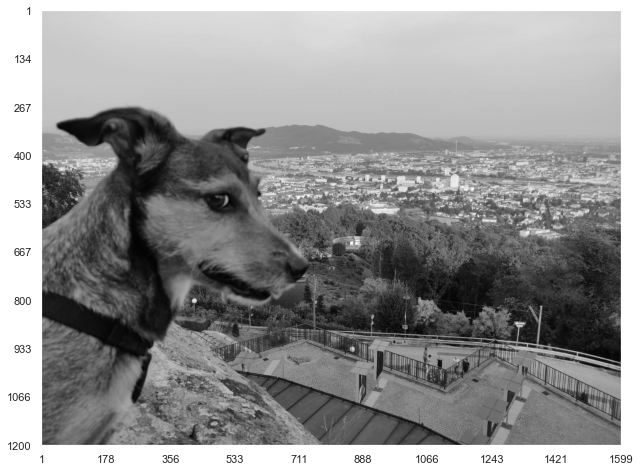

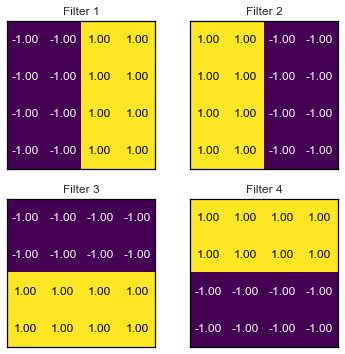

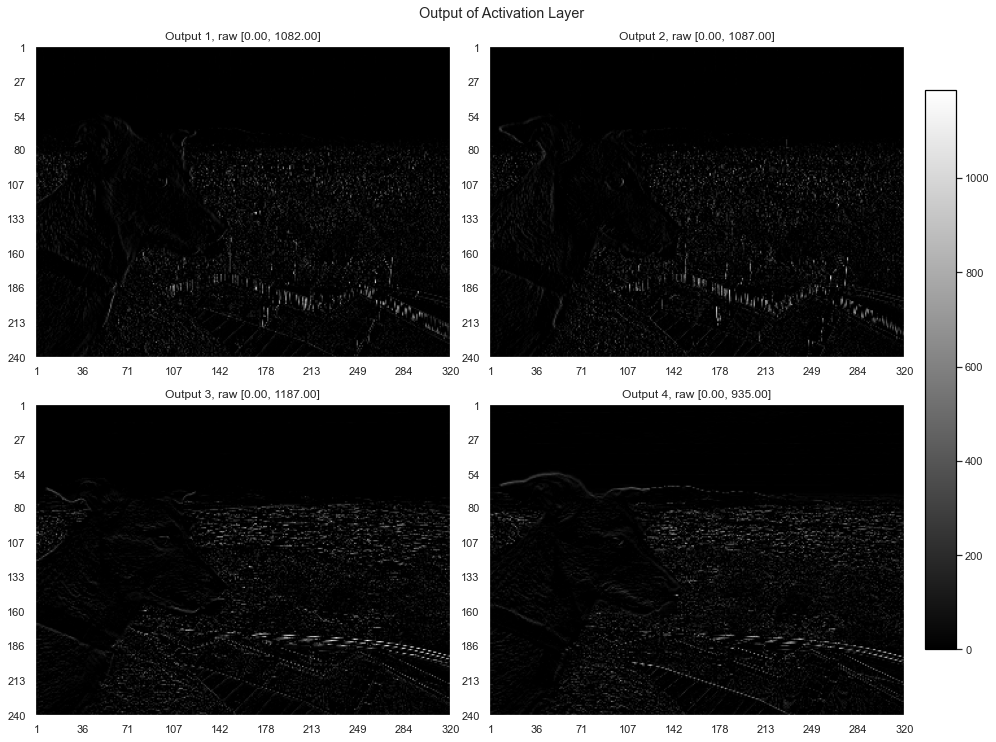

In [ ]:
u6.show_image(image)
u6.visualize_filters(filters)

# The stride of the convolutional layer can be changed
model = u6.InitializedNet(weights=filters, filter_stride=5)  # equivalent to (5, 5) which is read as (height, width)

# Get the convolutional layer before and after activation
conv_layer, activated_layer, _ = model(image_tensor)
# Visualize the output of the activation layer
u6.visualize_cnn_layer(activated_layer, title="Output of Activation Layer")

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>What happens if you change the stride?</li>
        <li>Apply your filters to the other images in the ''resources'' directory. What do you observe?</li>
    </ul>
</div>

<h3 style="color:rgb(0,120,170)">Stacking convolutional layers</h3>

The output of a convolutional layer or pooling layer is a set of images. We can convolve these again. But how do we convolve a set of images rather than a single image?

The same question occurs when the network input is not a grayscale image, but an RGB image. We usually represent it as a three-dimensional tensor, with dimensions *channels*, *height* and *width* (C, H, W). The solution is to define each learnable filter also with three dimensions: *channels* (same as the input), *height* and *width* (usually much smaller than the input). It computes the **sum** of the **channel-wise 2D convolutions**, so a single (multi-dimensional) filter still produces a single activation map.

For example, a convolutional layer of two 3-channel filters, i.e., shape (C=3, H=..., W=...), applied to a 3-channel image, i.e., shape (C=3, H=..., W=...), produces two activation maps, i.e., shape (C=2, H=..., W=...):

<img src="inputs/cnn_output_channels_1.png" width="436"/>

These form a 2-channel image for the next layer. Note that we need a nonlinear operation before the next convolutional layer, otherwise the two layers can be collapsed into a single one with a larger kernel size.

<h3 style="color:rgb(0,120,170)">Stacking fully-connected layers</h3>

For many tasks, the output still needs to be a vector and not an image. For example, for classification, we typically define our network to produce a vector of probabilities with one probability per class. How is this done in CNNs?

After a couple of layers, we can choose to stop treating the data as a multi-channel image, reshape the data into a vector (called **flattening**) and apply one or more fully-connected layers. These layers then have to integrate the information from all spatial locations to produce the final output.

For a nice visualization, see this link: https://poloclub.github.io/cnn-explainer/

<h1 style="color:rgb(0,120,170)">Building a CNN for MNIST</h1>

In the previous lecture, we already trained a neural network on the MNIST dataset for handwritten digit recognition [MNIST database (Modified National Institute of Standards and Technology database)](http://yann.lecun.com/exdb/mnist/). For our first self-built CNN, we will work with this dataset again.

<h2 style="color:rgb(0,120,170)">Preparation</h2>

<div class="alert alert-warning">
    <b>Hint:</b> If you copy the corresponding data folder from the last lecture or exercise, or adapt the root path given here, it will not have to download the dataset again.
</div>

<h2 style="color:rgb(0,120,170)">Model architecture and model training</h2>

We now look at a very simple convolutional network:
1) one convolutional layer with 10 kernels and kernel size of 5 (width = height)
2) a ReLU activation function
3) one max pooling layer with a size of 4 (width = height)
4) two fully connected layers with a ReLU activation function in between

For training the network, we use the same hyperparameters (learning rate, momentum, etc.) as in the last exercise. Let's see what results we get!

In [ ]:
# Load dataset with a batch size of 20 and 10% of examples as a validation set
train_loader, valid_loader, test_loader = u6.get_dataset(variant="MNIST", root="resources", batch_size=20, valid_size=0.1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\train-images-idx3-ubyte.gz to resources\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\train-labels-idx1-ubyte.gz to resources\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\t10k-images-idx3-ubyte.gz to resources\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\t10k-labels-idx1-ubyte.gz to resources\MNIST\raw



In [ ]:
# Define the model (set seed for reproducibility)
u6.set_seed(seed=42)
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # conv layer: size changes from (1, 28, 28) to (10, 24, 24); 24 because kernel with size 5 must fit 2 pixels left+right (top+bottom)
    torch.nn.ReLU(),                                                 # nonlinearity
    torch.nn.MaxPool2d(kernel_size=4),                               # max pooling layer: size changes from (10, 24, 24) to (10, 6, 6)
    torch.nn.Flatten(),                                              # flatten activation maps: size changes from (10, 6, 6) to 1D shape of size (10 * 6 * 6)
    torch.nn.Linear(10 * 6 * 6, 100),                                # first fully connected layer
    torch.nn.ReLU(),                                                 # nonlinearity
    torch.nn.Linear(100, 10)                                         # output layer
)

# Define the loss function
loss = torch.nn.functional.cross_entropy

# Minimize the given loss for our CNN model (set seed for reproducibility)
u6.set_seed(seed=42)
losses = u6.run_gradient_descent(
    model=model,
    loss=loss,
    training_set=train_loader,
    valid_set=valid_loader,
    iterations=5,
    learning_rate=0.01,
    momentum=0.9,
    use_cuda_if_available=True
)

  0%|          | 0/54000 [00:00<?, ?it/s]

Epoch  1 finished with training loss: 0.165245 and validation loss: 0.095667
Epoch  2 finished with training loss: 0.062258 and validation loss: 0.070984
Epoch  3 finished with training loss: 0.045154 and validation loss: 0.054971
Epoch  4 finished with training loss: 0.037392 and validation loss: 0.051642
Epoch  5 finished with training loss: 0.031208 and validation loss: 0.053327


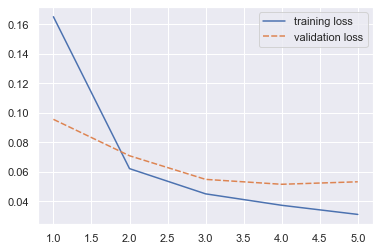

Training set:
{'loss': 0.018759890900610452, 'accuracy': 0.9943333320485221}
Test set:
{'loss': 0.03976572497038797, 'accuracy': 0.9884999976158142}


In [ ]:
sns.lineplot(data=losses)
plt.show()

print("Training set:")
print(u6.evaluate_model(model, train_loader, loss=loss, accuracy=u6.multiclass_accuracy))
print("Test set:")
print(u6.evaluate_model(model, test_loader, loss=loss, accuracy=u6.multiclass_accuracy))

As we see above, we already get nearly perfect results without any tweaking of the hyperparameters. CNNs are designed for processing images and naturally work well and perform better than a fully-connected neural network (like the ones we trained in the previous lecture) on such tasks. Since MNIST is a very easy dataset, it's not really a challenge for our CNN.

<h2 style="color:rgb(0,120,170)">How do our filters look like?</h2>

In the first part of the notebook, we invested quite some time to define custom filters and learn how they are applied to an image. Now, after we trained our first CNN, we want to know which filters our CNN learned to solve our task.

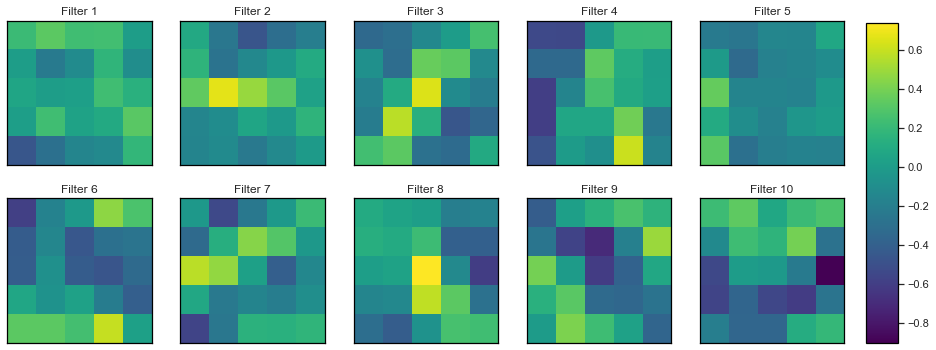

In [ ]:
u6.visualize_cnn_filters(model[0], ncols=5)

<h1 style="color:rgb(0,120,170)">Moving on to a more difficult task</h1>

To give you the chance to do some tweaking, we will move on to a more difficult classifiation task, **FashionMNIST**. Like the MNIST dataset, the Fashion-MNIST has input images of $28 \times 28$ pixels, and $10$ classes. 

More information about the dataset can be found in this publication: <br>
<i>Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf (2017). arXiv:1708.07747 </i>

<h2 style="color:rgb(0,120,170)">Preparation</h2>

<div class="alert alert-warning">
    <b>Hint:</b> If you copy the corresponding data folder from the last lecture or exercise, or adapt the root path given here, it will not have to download the dataset again.
</div>

<h2 style="color:rgb(0,120,170)">Our CNN for FashionMNIST</h2>

As the image size and the number of classes for FashionMNIST is identical to MNIST, we can copy our code from above and only need to change the dataloader to run it. Let's see how well our architecture and our hyperparameter settings work on FashionMNIST:

In [ ]:
# Load dataset with a batch size of 20 and 10% of examples as a validation set
# Change the dataset to FashionMNIST
train_loader, valid_loader, test_loader = u6.get_dataset(variant="FashionMNIST", root="resources", batch_size=20, valid_size=0.1)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting resources\FashionMNIST\raw\train-images-idx3-ubyte.gz to resources\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting resources\FashionMNIST\raw\train-labels-idx1-ubyte.gz to resources\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting resources\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to resources\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting resources\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to resources\FashionMNIST\raw



In [ ]:
# Define the model (set seed for reproducibility)
u6.set_seed(seed=42)
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # conv layer: size changes from (1, 28, 28) to (10, 24, 24)
    torch.nn.ReLU(),                                                 # nonlinearity
    torch.nn.MaxPool2d(kernel_size=4),                               # max pooling layer: size changes from (10, 24, 24) to (10, 6, 6)
    torch.nn.Flatten(),                                              # flatten activation maps: size changes from (10, 6, 6) to 1D shape of size (10 * 6 * 6)
    torch.nn.Linear(10 * 6 * 6, 100),                                # first fully connected layer
    torch.nn.ReLU(),                                                 # nonlinearity
    torch.nn.Linear(100, 10)                                         # output layer
)

# Define the loss function
loss = torch.nn.functional.cross_entropy

# Minimize the given loss for our CNN model (set seed for reproducibility)
u6.set_seed(seed=42)
losses = u6.run_gradient_descent(
    model=model,
    loss=loss,
    training_set=train_loader,
    valid_set=valid_loader,
    iterations=5,
    learning_rate=0.01,
    momentum=0.9,
    use_cuda_if_available=True
)

  0%|          | 0/54000 [00:00<?, ?it/s]

Epoch  1 finished with training loss: 0.459391 and validation loss: 0.322675
Epoch  2 finished with training loss: 0.327315 and validation loss: 0.327331
Epoch  3 finished with training loss: 0.298310 and validation loss: 0.291017
Epoch  4 finished with training loss: 0.282630 and validation loss: 0.306376
Epoch  5 finished with training loss: 0.265404 and validation loss: 0.294823


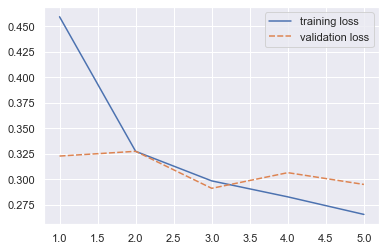

Training set:
{'loss': 0.2608648404998153, 'accuracy': 0.8974444399498127}
Test set:
{'loss': 0.3221398732131347, 'accuracy': 0.8760999982357025}


In [ ]:
sns.lineplot(data=losses)
plt.show()

print("Training set:")
print(u6.evaluate_model(model, train_loader, loss=loss, accuracy=u6.multiclass_accuracy))
print("Test set:")
print(u6.evaluate_model(model, test_loader, loss=loss, accuracy=u6.multiclass_accuracy))

We see above, that we get good results but quite a bit worse than we could achieve for MNIST. Now it's time for you to tweak parameters :-)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Improve the scores! Can you reach a test accuracy of at least 90%?</li>
        <li>Aspects to vary:
            <ul>
                <li>training parameters: batch size, iterations, learning rate, momentum</li>
                <li>size (number of nodes) of fully-connected layer</li>
                <li>number of kernels of convolutional layer</li>
                <li>number of layers (do not forget the nonlinearities after linear and conv layers!)</li>
                <li>kernel size for pooling</li>
                <li>kernel size for convolution (stick with an odd number!)</li>
                <li>type of nonlinearity (Sigmoid(), Tanh(), ReLU(), ELU(), ...)</li>
            </ul>
        </li>
        <li>Can you get the model to overfit? I.e., obtaining a better training error, but a worse test error?</li>
    </ul>
</div>